In [ ]:
from google.colab import files
files.upload()

Saving tigershark.jpg to tigershark.jpg


{'tigershark.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\n\x07\x08\x16\x15\x15\x18\x15\x15\x15\x18\x18\x18\x18\x1a\x18\x19\x18\x19\x1a\x1a\x18\x18\x18\x18\x18\x1a\x18\x1a\x1a\x18\x1a\x18\x19\x1c!.%\x1c\x1e+!\x18\x18&8&+/1555\x1a$;@;4?.451\x01\x0c\x0c\x0c\x10\x0f\x10\x1e\x12\x12\x1e4,$+44414444444444444444444444444444444444444444444444\xff\xc0\x00\x11\x08\x00\xb0\x01\x1e\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x01\x04\x05\x00\x06\x07\xff\xc4\x007\x10\x00\x01\x03\x02\x04\x04\x03\x06\x06\x02\x02\x03\x00\x00\x00\x00\x01\x00\x02\x11\x03!\x04\x121A\x05Qaq\x81\x91\xb1\x06\x13"\xa1\xc1\xf02BR\xd1\xe1\xf1\x14b3r\x15\x82\xa2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00*\x11\x00\x02\x02\x02\x01\x04\x01\x03\x03\x05\x00\x00\x00\x00\x00\x00\x00\x01\x02\x11\x03\x12!\x131AQ\x04"2a\x81

In [ ]:
input_image_1 = Image.open('tigershark.jpg')
input_image_2 = Image.open('greatwhiteshark.jpg')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)




---




---

GET ACTIVATION GRIDS

https://github.com/greentfrapp/lucent

https://colab.research.google.com/github/greentfrapp/lucent-notebooks/blob/master/notebooks/activation_grids.ipynb#scrollTo=MkUFyQQaulHs

In [ ]:
!pip install torch-lucent

In [ ]:
!pip install --quiet git+https://github.com/greentfrapp/lucent

!wget -qnc https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png

In [ ]:
from itertools import product
import sys
from PIL import Image

import numpy as np
import torch
import torchvision

from lucent.modelzoo import *
from lucent.misc.io import show
import lucent.optvis.objectives as objectives
import lucent.optvis.param as param
import lucent.optvis.render as render
import lucent.optvis.transform as transform
from lucent.misc.channel_reducer import ChannelReducer
from lucent.misc.io import show

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True)
_ = model.to(device).eval()

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /root/.cache/torch/hub/checkpoints/inception5h.pth


  0%|          | 0.00/27.0M [00:00<?, ?B/s]

In [ ]:
@torch.no_grad()
def get_layer(model, layer, X):
    hook = render.ModuleHook(getattr(model, layer))
    model(X)
    hook.close()
    return hook.features


@objectives.wrap_objective()
def dot_compare(layer, acts, batch=1):
    def inner(T):
        pred = T(layer)[batch]
        return -(pred * acts).sum(dim=0, keepdims=True).mean()

    return inner

In [ ]:
def render_activation_grid_very_naive(
    img, model, layer="mixed4d", cell_image_size=48, n_steps=1024
):
    # First we need to normalize and resize the image
    img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
    normalize = (
        transform.preprocess_inceptionv1()
        if model._get_name() == "InceptionV1"
        else transform.normalize()
    )
    transforms = [
        normalize,
        torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
    ]
    transforms_f = transform.compose(transforms)
    # shape: (1, 3, original height of img, original width of img)
    img = img.unsqueeze(0)
    # shape: (1, 3, 224, 224)
    img = transforms_f(img)

    # Here we compute the activations of the layer `layer` using `img` as input
    # shape: (layer_channels, layer_height, layer_width), the shape depends on the layer
    acts = get_layer(model, layer, img)[0]
    layer_channels, layer_height, layer_width = acts.shape
    # for each position `(y, x)` in the feature map `acts`, we optimize an image
    # to match with the features `acts[:, y, x]`
    # This means that the total number of cells (which is the batch size here) 
    # in the grid is layer_height*layer_width.
    nb_cells = layer_height * layer_width

    # Parametrization of each cell in the grid
    param_f = lambda: param.image(
        cell_image_size, batch=nb_cells
    )
    params, image_f = param_f()

    obj = objectives.Objective.sum(
        [
            # for each position in `acts`, maximize the dot product between the activations
            # `acts` at the position (y, x) and the features of the corresponding
            # cell image on our 'grid'. The activations at (y, x) is a vector of size
            # `layer_channels` (this depends on the `layer`). The features
            # of the corresponding cell on our grid is a tensor of shape
            # (layer_channels, cell_layer_height, cell_layer_width).
            # Note that cell_layer_width != layer_width and cell_layer_height != layer_weight
            # because the cell image size is smaller than the image size.
            # With `dot_compare`, we maximize the dot product between
            # cell_activations[y_cell, x_xcell] and acts[y,x] (both of size `layer_channels`)
            # for each possible y_cell and x_cell, then take the average to get a single
            # number. Check `dot_compare for more details.`
            dot_compare(layer, acts[:, y:y+1, x:x+1], batch=x + y * layer_width)
            for i, (x, y) in enumerate(product(range(layer_width), range(layer_height)))
        ]
    )
    results = render.render_vis(
        model,
        obj,
        param_f,
        thresholds=(n_steps,),
        progress=True,
        fixed_image_size=cell_image_size,
        show_image=False,
    )
    # shape: (layer_height*layer_width, cell_image_size, cell_image_size, 3)
    imgs = results[-1] # last step results
    # shape: (layer_height*layer_width, 3, cell_image_size, cell_image_size)
    imgs = imgs.transpose((0, 3, 1, 2))
    imgs = torch.from_numpy(imgs)
    imgs = imgs[:, :, 2:-2, 2:-2]
    # turn imgs into a a grid
    grid = torchvision.utils.make_grid(imgs, nrow=int(np.sqrt(nb_cells)), padding=0)
    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    render.show(grid)
    return imgs

  0%|          | 0/1024 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lucent/optvis/render.py:104: UserWarning: Some layers could not be computed because the size of the image is not big enough. It is fine, as long as the noncomputed layers are not used in the objective function(exception details: 'Given input size: (1024x1x1). Calculated output size: (1024x-5x-5). Output size is too small')
  "Some layers could not be computed because the size of the "
100%|██████████| 1024/1024 [05:37<00:00,  3.03it/s]



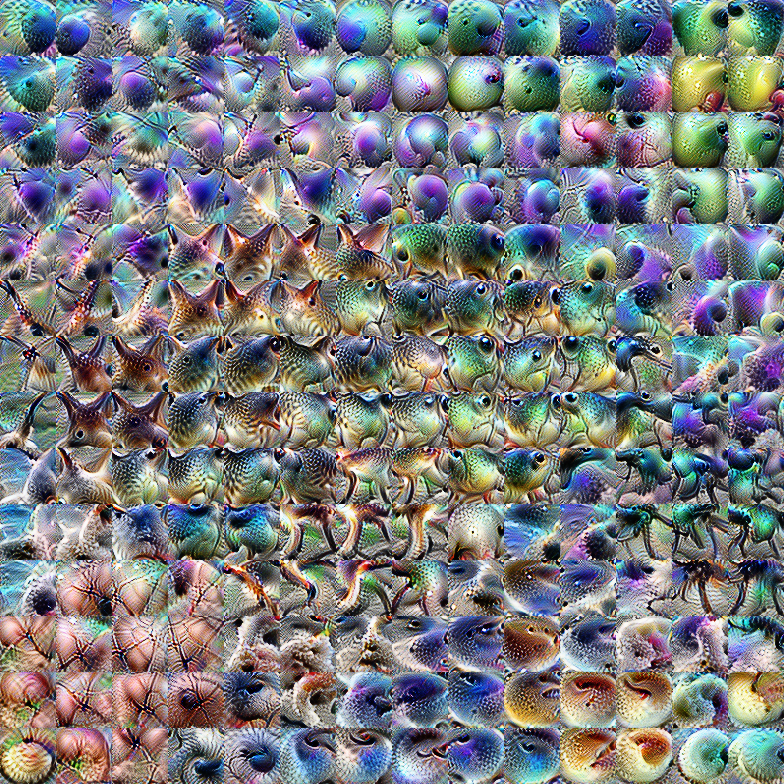

In [ ]:
img = np.array(Image.open("tigershark.jpg"), np.float32)
_ = render_activation_grid_very_naive(img, model, cell_image_size=60, n_steps=1024)